# Optimización de las transiciones de una red de Damman con PySwarms

**Autor**: Ángela Soria García

**Fecha**: 11/10/2021

**Objetivo**: Desarrollar un procedimiento de optimización para las transiciones de una red de Damman.

**Descripción**: Implementamos una función que calcule las eficiencias del órdenes de difracción de la red de Damman. Las expresiones utilizadas son las dadas en el Optixplorer_Manual_v2.8d (pág 29). Con la librería PySwarms optimizamos estas transiciones para que la energía de todos los órdenes sea igual.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.single.local_best import LocalBestPSO
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
from pyswarms.utils.plotters.formatters import Mesher

In [3]:
#transitions=np.array([0, 0.201181, 0.250978, 0.326167,  0.370555,  0.372996,  0.396478,
#                    0.453128,  0.594731, 0.670591, 0.717718,  0.890632, 0.919921, 0.935546])

In [16]:
def Optimize_Damman(x,number_transitions,num_orders,n_particles):
    """""
    x: np.array 
    number_transitons: int
    num_orders: int
    
    """""
    phase_shift=np.pi
    orders = np.arange(-num_orders,num_orders+1)
    efficiencies = np.zeros((n_particles,len(orders)))
    
    ef_max = np.zeros(n_particles)
    ef_min = np.ones(n_particles)*(1/len(orders))
    sumatorio = 0
    
    for i, l in enumerate(orders):

            S, C, Q = 0, 0, 0

            for k in range(number_transitions):

                S = S + (-1)**(k+1) * np.sin(2*np.pi*l * x[:,k])
                C = C + (-1)**(k+1) * np.cos(2*np.pi*l * x[:,k])
                Q = Q + (-1)**(k+1) * (x[:,k])

            if l==0:
                ef = 1 - 4*Q*(1-Q)*np.sin(phase_shift/2)**2
                #print('EF_0',ef)

            else: 
                ef = np.sin(phase_shift/2)**2/(phase_shift*l)**2 * (C**2 + S**2)

            efficiencies[:,i] = ef
           
            sumatorio = sumatorio + (1/len(orders) - ef)**2
            
            if np.any(ef)>np.any(ef_max):
                ef_max = ef
            
            if np.any(ef)<np.any(ef_min):
                ef_min = ef
                
            #print('Eficiencia',len(efficiencies[1]))
    
    #Función de coste: Desviación estándar
    media = np.zeros(n_particles)
    cost = np.zeros(n_particles)
    for h in range(n_particles):
        media[h] = np.sum(efficiencies[h,:])/len(orders)
    
    
    for j in range(len(orders)):
        cost = cost + np.abs(efficiencies[:,j]-media[:])**2
       
    
    
    cost = cost/len(orders) #+ (ef_max-ef_min)**2 

    #print(cost)
    
    #cost = sum(1/len(orders) - eficiencias[:])**2
    #print(sum(efficiencies))
    #print(cost)
    #Función que queremos minimizar es la función de coste
    return cost

El número de dimensiones del problema corresponde con el número de transiciones de la red de Damman. El número de órdenes corresponde con los órdenes de difracción de la red.

In [6]:
dimensions = 4
num_orders = 3
n_particles = 50

Es necesario incluir unos límites entre los que tienen que oscilar las transiciones de la red (Sería entre 0 y el periodo de la red). En este ejemplo varían entre 0 y 1:

In [7]:
min_bound = np.zeros(dimensions)
max_bound = np.ones(dimensions)
bounds = (min_bound, max_bound)

Utilizamos la función GlobalBestPSO de PySwarms para optimizar la función, cuyos argumentos son los siguientes:

- n_particles: # de partículas que el algoritmo utiliza para alcanzar el mínimo.
- dimensions: Las dimensiones corresponde con las trasiciones de nuestra red.
- options: 
   * c1 : float
      cognitive parameter
   * c2 : float
        social parameter
   * w : float
        inertia parameter 
- bounds: Restricciones mínima y máxima de las transiciones de la red



In [8]:
%%time

options = {'c1': 0.5, 'c2': 0.6, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=options,bounds=bounds)

cost, pos = optimizer.optimize(Optimize_Damman, iters=1500,number_transitions=dimensions,num_orders=num_orders,n_particles=n_particles)

2021-10-27 16:37:35,244 - pyswarms.single.global_best - INFO - Optimize for 1500 iters with {'c1': 0.5, 'c2': 0.6, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████|1500/1500, best_cost=3.03e-34
2021-10-27 16:37:49,254 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.026461341179942e-34, best pos: [0.27034891 0.79606056 0.69555071 0.50226339]


Wall time: 14 s


In [9]:
pos.sort()
print(pos)

[0.27034891 0.50226339 0.69555071 0.79606056]


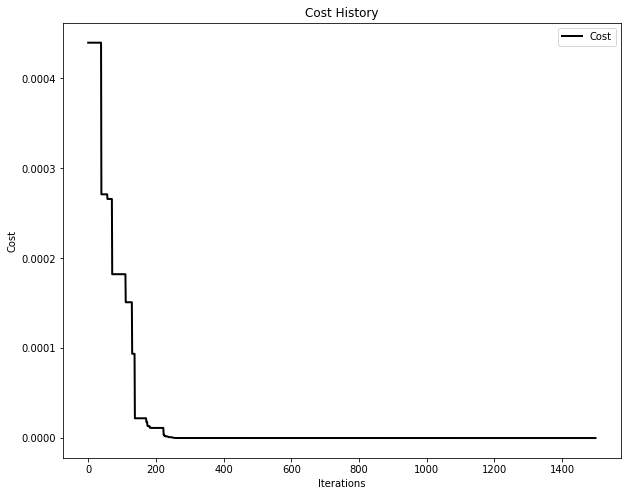

In [10]:
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

## Comprobación de la optimización

In [11]:
def Damman_efficiencies(num_orders, transitions, phase_shift=np.pi):
    
    period = 1
    orders = np.arange(-num_orders,num_orders+1)
    efficiencies = np.zeros_like(orders, dtype=float)
    
    for i, l in enumerate(orders):

            S, C, Q = 0, 0, 0

            for k, xk in enumerate(transitions):

                S = S + (-1)**(k+1) * np.sin(2*np.pi*l * xk/period)
                C = C + (-1)**(k+1) * np.cos(2*np.pi*l * xk/period)
                Q = Q + (-1)**(k+1) * (xk/period)

            if l==0:
                ef = 1 - 4*Q*(1-Q)*np.sin(phase_shift/2)**2

            else: 
                ef = np.sin(phase_shift/2)**2/(phase_shift*l)**2 * (C**2 + S**2)

            efficiencies[i] = ef
        
    return efficiencies,orders

In [12]:
efficiencies,orders= Damman_efficiencies(num_orders,pos)

Text(0, 0.5, 'Intensities')

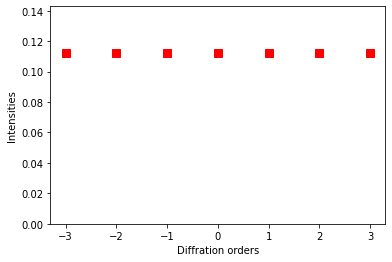

In [15]:
#Comprobación
plt.plot(orders,efficiencies ,'rs',ms=8)
plt.ylim(ymin=0)
plt.ylim(ymax=1/len(orders))
plt.xlabel('Diffration orders');plt.ylabel('Intensities')
#print(1/len(orders))